In [5]:
import glob
import multiprocessing
import os
import numpy as np
import torch
import torchvision.transforms as transforms
from torch.autograd import Variable
from PIL import Image
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

os.chdir('../..')

cuda = True

def colorize(y, ycbcr):
    img = np.zeros((y.shape[0], y.shape[1], 3), np.uint8)
    img[:, :, 0] = y
    img[:, :, 1] = ycbcr[:, :, 1]
    img[:, :, 2] = ycbcr[:, :, 2]
    img = cv2.cvtColor(img, cv2.COLOR_YCrCb2BGR)
    return img

def model_vdsr(model, img_lr):
    img_lr_y = img_lr[:, :, 0].astype(float)

    input = img_lr_y/255.

    input = Variable(torch.from_numpy(input).float()).view(
        1, -1, input.shape[0], input.shape[1])

    if cuda:
        model = model.cuda()
        input = input.cuda()
    else:
        model = model.cpu()

    out = model(input)

    out = out.cpu().clone()

    im_h_y = out.data[0].numpy().astype(np.float32)

    im_h_y = im_h_y * 255.
    im_h_y[im_h_y < 0] = 0
    im_h_y[im_h_y > 255.] = 255.

    return colorize(im_h_y[0, :, :], img_lr)

In [6]:
class Hook(object):
    def __init__(self):
        self.module_name = []
        self.features_in_hook = []
        self.features_out_hook = []


    def __call__(self,module, fea_in, fea_out):
        print("hooker working", self)
        self.module_name.append(module.__class__)
        self.features_in_hook.append(fea_in)
        self.features_out_hook.append(fea_out)
        return None

Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
ReLU(inplace=True)
Conv_ReLU_Block(
  (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (relu): ReLU(inplace=True)
)
Conv_ReLU_Block(
  (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (relu): ReLU(inplace=True)
)
Conv_ReLU_Block(
  (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (relu): ReLU(inplace=True)
)
Conv_ReLU_Block(
  (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (relu): ReLU(inplace=True)
)
Conv_ReLU_Block(
  (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (relu): ReLU(inplace=True)
)
Conv_ReLU_Block(
  (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (relu): ReLU(inplace=True)
)
Conv_ReLU_Block(
  (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1,

/root/miniconda3/envs/TEST/lib/python3.7/site-packages/ipykernel_launcher.py:49: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


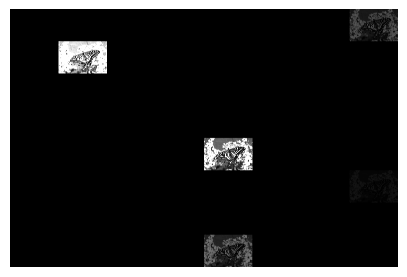

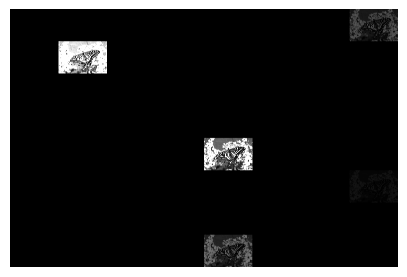

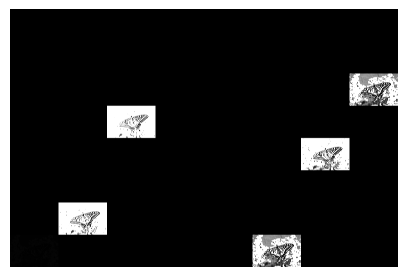

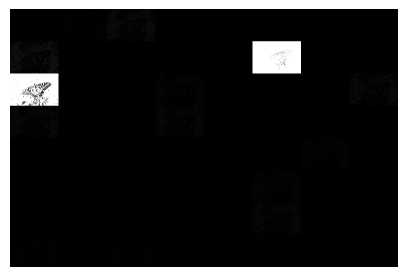

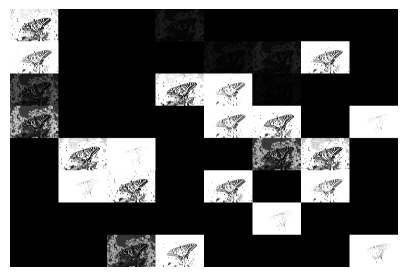

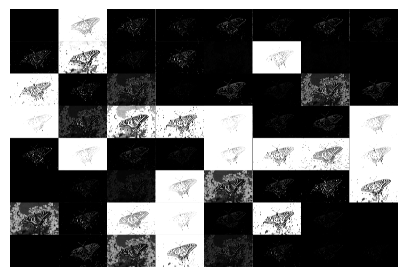

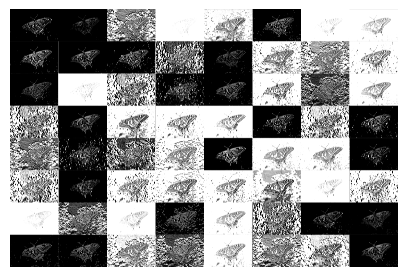

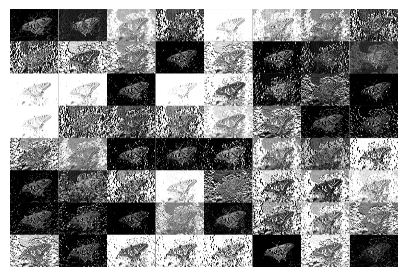

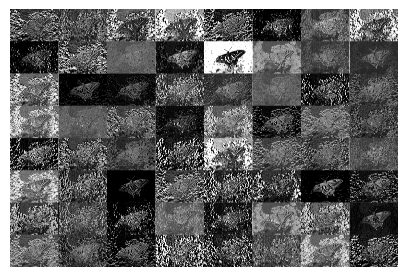

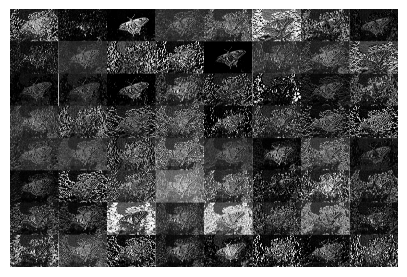

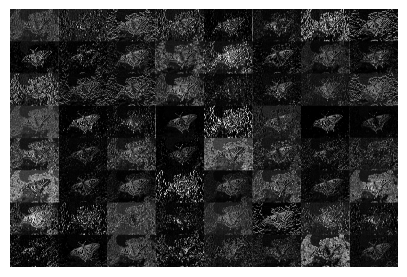

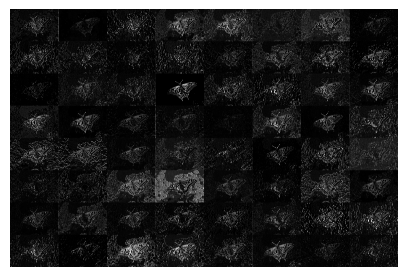

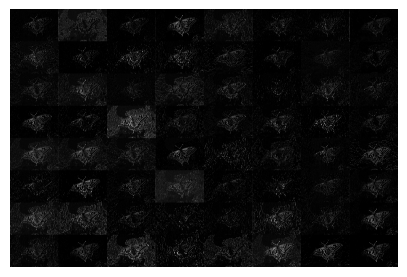

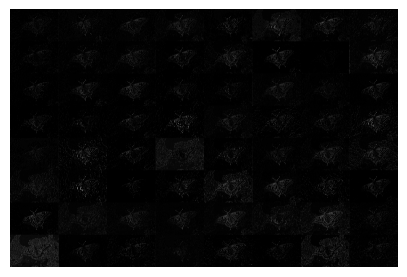

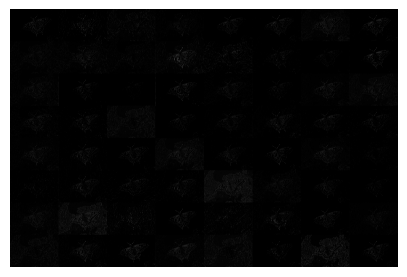

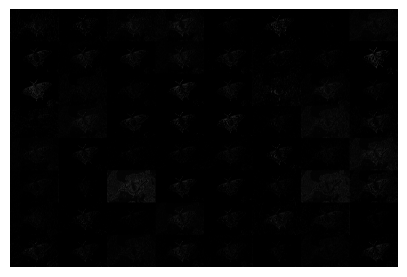

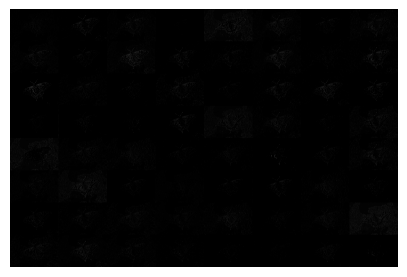

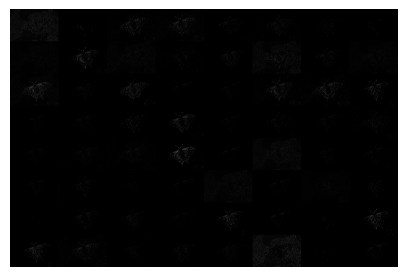

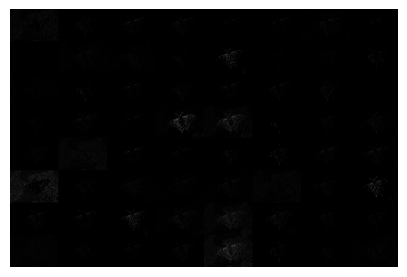

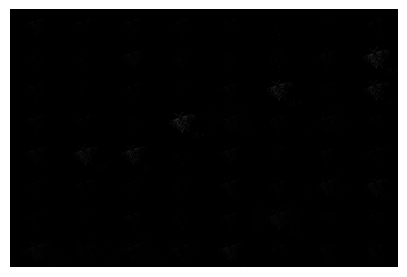

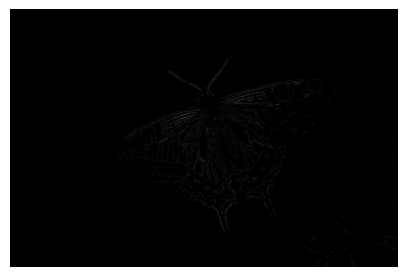

In [8]:
scale = 4
model_file = r'models/vdsr234/model_epoch_5.pth'
model = torch.load(model_file)["model"]

visualisation = {}

def hook_fn(m, i, o):
  visualisation[m] = (i, o)

def get_all_layers(net):
  for name, layer in net._modules.items():
    #If it is a sequential, don't register a hook on it
    # but recursively register hook on all it's module children
    if isinstance(layer, torch.nn.Sequential):
      get_all_layers(layer)
    else:
      # it's a non sequential. Register a hook
      layer.register_forward_hook(hook_fn)

get_all_layers(model)

img = cv2.imread("dataset/DIV2K_valid_HR/0882.png")
img_lr = cv2.resize(img, dsize=(int(img.shape[1]/scale), int(img.shape[0]/scale)),
                    interpolation=cv2.INTER_CUBIC)
img_lr = cv2.resize(img_lr, dsize=(int(img.shape[1]), int(img.shape[0])),
                    interpolation=cv2.INTER_CUBIC)
img_lr_ycrcb = cv2.cvtColor(img_lr,cv2.COLOR_BGR2YCrCb)
img = model_vdsr(model, img_lr)

for layer, [feat_in_group, feat_out_group] in visualisation.items():
  print(layer)
  for feat_out_imgs in feat_out_group:
    # for feat_img in feat_imgs:
    feat_imgs = feat_out_imgs.clone().cpu().detach().numpy()
    feat_imgs *= 255.0
    feat_imgs = feat_imgs.clip(0, 255)
    
    cols = int(np.round(np.sqrt(feat_imgs.shape[0])))
    tiled_img = []
    lst_imgs = []
    for i in range(feat_imgs.shape[0]):
      lst_imgs.append(feat_imgs[i])
      if lst_imgs.__len__() >= cols:
        ppp = np.concatenate(lst_imgs, axis=1)
        tiled_img.append(ppp)
        lst_imgs = []
    m = np.concatenate(tiled_img, axis=0)

    plt.figure(figsize=(5, 5))
    plt.xticks([]), plt.yticks([])
    plt.axis('off')
    # plt.title(layer)
    plt.imshow(m, cmap='gray')
